In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime, timedelta
from dateparser import parse
import re
from sklearn.pipeline import Pipeline
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD 
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsRegressor
import shap
from sklearn.metrics import r2_score
from sklearn.base import clone
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.corpus import stopwords
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import scipy.cluster.hierarchy as sch
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neural_network import MLPRegressor

In [3]:
# Load data
tweet_data = pd.read_csv("Prabowo_All2.csv", delimiter='\t', header=None, names=['data'])
tweet_data = tweet_data['data'].str.split(';', expand=True)
tweet_data.columns = ['created_at', 'id_str', 'full_text', 'quote_count', 'reply_count',
                      'retweet_count', 'favorite_count', 'lang', 'user_id_str',
                      'conversation_id_str', 'username', 'tweet_url']

# Function for text preprocessing
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove special characters and numbers, keep only letters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove stopwords
    stopword_factory = StopWordRemoverFactory()
    stopword_remover = stopword_factory.create_stop_word_remover()
    text = stopword_remover.remove(text)
    
    return text

# Apply text preprocessing to your data
tweet_data['cleaned_full_text'] = tweet_data['full_text'].astype(str).apply(preprocess_text)

# Load survey data
survey_data = pd.read_excel('Electionforcode_Prabowo3.xlsx')
tweet_data['date'] = pd.to_datetime(tweet_data['created_at'], format='%a %b %d %H:%M:%S +0000 %Y', errors='coerce')
tweet_data = tweet_data.dropna(subset=['date'])

# Extract the 'Numbers of Candidate' column
numbers_of_candidate = survey_data['Numbers of Candidate']

# Assuming the "Polling firm" column exists in your survey data
survey_data['Polling firm'] = survey_data['Polling firm'].astype(str)

# Perform one-hot encoding on the "Polling firm" column
survey_data = pd.get_dummies(survey_data, columns=['Polling firm'], prefix='polling')

def preprocess_text_eng(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove special characters and numbers, keep only letters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()

    # Remove English stopwords
    english_stopwords = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in english_stopwords]
    text = ' '.join(filtered_words)
    
    return text

file_data = pd.read_excel('Phenomena2.xlsx')
file_data['cleaned_Phenomenon'] = file_data['Phenomenon'].astype(str).apply(preprocess_text_eng)
file_data['date'] = pd.to_datetime(file_data['Date'], format='%a %b %d %H:%M:%S +0000 %Y', errors='coerce')
file_data = file_data.dropna(subset=['date'])

# Create lists of feature names for each type of feature
word2vec_tweet_features = ["word2vec_tweet_" + str(i) for i in range(100)]
word2vec_event_features = ["word2vec_event_" + str(i) for i in range(100)]
polling_firm_feature_names = ["polling_firm_" + str(i) for i in range(len(survey_data.filter(like='polling_').columns))]
numerical_feature_names = ["number_of_candidates"]

# Concatenate feature names before combining features
all_feature_names = (
    word2vec_tweet_features
    + word2vec_event_features
    + polling_firm_feature_names
    + numerical_feature_names
)

In [4]:
# Create an empty list to store the feature names for each survey result
survey_result_feature_names = []
# Prepare features (X) and target (y)
survey_results = []  # To store survey data
# Create a loop to process survey data and perform Word2Vec with an additional Events feature
for index, row in survey_data.iterrows():
    # Define the date range from your survey data and process it
    date_range = row['Date Range']
    date_parts = date_range.split('-')
    start_date_str = date_parts[0].strip()
    end_date_str = date_parts[1].strip()
    start_date = parse(start_date_str)
    end_date = parse(end_date_str)
    
    # Define the tweet date range
    tweet_start_date = start_date - timedelta(days=7)
    tweet_end_date = end_date + timedelta(days=7)
    
    # Filter tweets within the date range
    tweets_in_interval = tweet_data[(tweet_data['date'] >= tweet_start_date) & (tweet_data['date'] <= tweet_end_date)]
 
    # Extract cleaned text as a list
    cleaned_texts = tweets_in_interval['cleaned_full_text'].astype(str).tolist()
    
    # Create a list of tokenized sentences for tweets
    tokenized_sentences_tweets = [word_tokenize(text) for text in cleaned_texts]

    # Train Word2Vec model for tweets
    word2vec_model_tweets = Word2Vec(tokenized_sentences_tweets, vector_size=100, window=5, min_count=1, sg=0)
    
    # Create document vectors by averaging the word vectors for tweets
    document_vectors_tweets = []
    for sentence in tokenized_sentences_tweets:
        word_vectors = [word2vec_model_tweets.wv[word] for word in sentence if word in word2vec_model_tweets.wv]
        if word_vectors:
            doc_vector = np.mean(word_vectors, axis=0)
            document_vectors_tweets.append(doc_vector)
        else:
            # If no word vectors found in a sentence, add a zero vector
            document_vectors_tweets.append(np.zeros(100))

    # Calculate the average Word2Vec vector for the tweets in the interval
    avg_word2vec_tweets = np.mean(document_vectors_tweets, axis=0)
    
    # Get the one-hot encoded features for the "Polling firm"
    polling_firm_features = row.filter(like='polling_').values
    
    # Get the 'Numbers of Candidate' feature
    numbers_of_candidate_value = row['Numbers of Candidate']

    # Define the date range for Events
    event_start_date = start_date - timedelta(days=17)
    event_end_date = end_date 
    
    # Filter Events within the date range
    events_in_interval = file_data[(file_data['date'] >= event_start_date) & (file_data['date'] <= event_end_date)]
    
    # Extract cleaned text as a list for Events
    cleaned_events = events_in_interval['cleaned_Phenomenon'].astype(str).tolist()
    
    # Create a list of tokenized sentences for Events
    tokenized_sentences_events = [word_tokenize(text) for text in cleaned_events]

    # Train Word2Vec model for Events
    word2vec_model_events = Word2Vec(tokenized_sentences_events, vector_size=100, window=5, min_count=1, sg=0)
    
    # Create document vectors by averaging the word vectors for Events
    document_vectors_events = []
    for sentence in tokenized_sentences_events:
        word_vectors = [word2vec_model_events.wv[word] for word in sentence if word in word2vec_model_events.wv]
        if word_vectors:
            doc_vector = np.mean(word_vectors, axis=0)
            document_vectors_events.append(doc_vector)
        else:
            # If no word vectors found in a sentence, add a zero vector
            document_vectors_events.append(np.zeros(100))

    # Calculate the average Word2Vec vector for the Events in the interval
    avg_word2vec_events = np.mean(document_vectors_events, axis=0)
    
    # Combine Word2Vec features for tweets and Events, along with polling firm features and the number of candidates
    combined_features = np.hstack(
        (avg_word2vec_tweets, avg_word2vec_events, polling_firm_features, [numbers_of_candidate_value])
    )
    
    # Append the feature names to the list
    feature_names_for_result = (
        word2vec_tweet_features
        + word2vec_event_features
        + polling_firm_feature_names
        + numerical_feature_names
    )
    survey_result_feature_names.append(feature_names_for_result)

    # Append the results to the list
    survey_results.append(combined_features)

# Create a DataFrame for survey results with feature names as columns
survey_results_df = pd.DataFrame(survey_results, columns=all_feature_names)
survey_result_feature_names_df = pd.DataFrame(survey_result_feature_names, columns=all_feature_names)
    

In [5]:
# Convert the results to NumPy arrays
X = np.array(survey_results)
# Extract the target variable from survey results
y = survey_data['Prabowo'].values.astype(float)

In [6]:
# Define the number of splits for time series cross-validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

In [6]:
# Initialize lists to store predictions for each fold
y_pred_rf = []

y_true = []  # Initialize a list to store true target value

In [7]:
# Perform time series cross-validation
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Create separate pipelines for each model
    pipeline_rf = Pipeline([
        ('rf', RandomForestRegressor(n_estimators=110, max_depth=10, random_state=42))  
    ])
    
    # Hyperparameter tuning for Random Forest
    param_grid_rf = {
        'rf__n_estimators': [100, 150, 200],
        'rf__max_depth': [5, 10, 15]
    }
    
    grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=tscv)
    grid_search_rf.fit(X_train, y_train)

    # Predict for the current fold
    y_pred_rf_fold = grid_search_rf.predict(X_test)

    # Append the predictions to the lists
    y_pred_rf.extend(y_pred_rf_fold)
    y_true.extend(y_test)  # Append true target values
    
# Convert the prediction lists to NumPy arrays
y_pred_rf = np.array(y_pred_rf)
y_true = np.array(y_true)
# Calculate MAE, MSE, and R2 for the Random Forest model
mae_rf = mean_absolute_error(y_true, y_pred_rf)
mse_rf = mean_squared_error(y_true, y_pred_rf)
r2_rf = r2_score(y_true, y_pred_rf)
print("Random Forest - Mean Absolute Error (MAE):", mae_rf)
print("Random Forest - Mean Squared Error (MSE):", mse_rf)
print("Random Forest - R-squared (R2) Score:", r2_rf)

Random Forest - Mean Absolute Error (MAE): 0.0556186785732018
Random Forest - Mean Squared Error (MSE): 0.004748091217759424
Random Forest - R-squared (R2) Score: 0.26549206717474816


Top-10 most important features:
['number_of_candidates', 'word2vec_event_committee', 'word2vec_tweet_mk', 'number_of_candidates', 'word2vec_tweet_dgn', 'number_of_candidates', 'word2vec_tweet_kalau', 'word2vec_event_mayor', 'word2vec_event_may', 'word2vec_tweet_md']


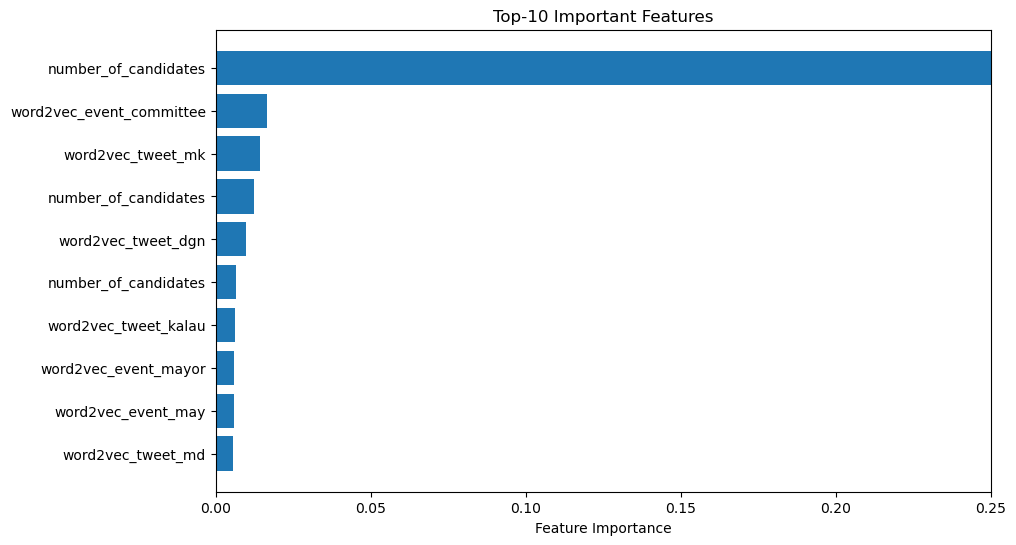

In [8]:
# Fit the grid search to the entire dataset
grid_search_rf.fit(X, y)

# Get the best estimator from the grid search
best_rf_estimator = grid_search_rf.best_estimator_

# Get feature importances from the best estimator
feature_importances = best_rf_estimator.named_steps['rf'].feature_importances_

k = 10
top_k_features = np.argsort(-feature_importances)[:k]

# Translate the top-k features back into their original word representations
top_k_words = []

for feature_index in top_k_features:
    if feature_index < 100:
        word = word2vec_model_tweets.wv.index_to_key[feature_index]
        top_k_words.append(f'word2vec_tweet_{word}')
    elif 100 <= feature_index < 200 and feature_index - 100 < len(word2vec_model_events.wv.index_to_key):
        word = word2vec_model_events.wv.index_to_key[feature_index - 100]
        top_k_words.append(f'word2vec_event_{word}')
    elif 200 <= feature_index < 200 + len(polling_firm_feature_names):
        word = polling_firm_feature_names[feature_index - 200]
        top_k_words.append(word)
    else:
        top_k_words.append('number_of_candidates')

print(f"Top-{k} most important features:")
print(top_k_words)

# Plot the top-k important features
plt.figure(figsize=(10, 6))
plt.barh(range(k), feature_importances[top_k_features][::-1], align='center')  # Reverse the order
plt.yticks(range(k), top_k_words[::-1])  # Reverse the order
plt.xlabel('Feature Importance')
plt.title(f'Top-{k} Important Features')
plt.xlim(0, 0.25)
plt.show()

In [14]:
# List untuk menyimpan prediksi dan target sebenarnya
y_pred_elasticnet = []
y_true_elasticnet = []

# Perform time series cross-validation
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Create separate pipelines for each model
    pipeline_elasticnet = Pipeline([
        ('elasticnet', ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42))  
    ])
    
    # Hyperparameter tuning for Elastic Net
    param_grid_elasticnet = {
        'elasticnet__alpha': [0.001, 0.01, 0.1],
        'elasticnet__l1_ratio': [0.2, 0.5, 0.8]
    }
    
    grid_search_elasticnet = GridSearchCV(pipeline_elasticnet, param_grid_elasticnet, cv=tscv)
    grid_search_elasticnet.fit(X_train, y_train)

    # Predict for the current fold
    y_pred_elasticnet_fold = grid_search_elasticnet.predict(X_test)

    # Append the predictions to the lists
    y_pred_elasticnet.extend(y_pred_elasticnet_fold)
    y_true_elasticnet.extend(y_test)  # Append true target values
    
# Convert the prediction lists to NumPy arrays
y_pred_elasticnet = np.array(y_pred_elasticnet)
y_true_elasticnet = np.array(y_true_elasticnet)

# Calculate MAE, MSE, and R2 for the Elastic Net model
mae_elasticnet = mean_absolute_error(y_true_elasticnet, y_pred_elasticnet)
mse_elasticnet = mean_squared_error(y_true_elasticnet, y_pred_elasticnet)
r2_elasticnet = r2_score(y_true_elasticnet, y_pred_elasticnet)

print("Elastic Net - Mean Absolute Error (MAE):", mae_elasticnet)
print("Elastic Net - Mean Squared Error (MSE):", mse_elasticnet)
print("Elastic Net - R-squared (R2) Score:", r2_elasticnet)

Elastic Net - Mean Absolute Error (MAE): 0.05205001412596546
Elastic Net - Mean Squared Error (MSE): 0.0040490938910862076
Elastic Net - R-squared (R2) Score: 0.37362374744760485


In [33]:
# List untuk menyimpan prediksi dan target sebenarnya
y_pred_knn = []
y_true_knn = []

# Perform time series cross-validation
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Create pipeline with feature selection and KNN
    pipeline_knn = Pipeline([
        ('svd', TruncatedSVD(n_components=20)),
        ('knn', KNeighborsRegressor(n_neighbors=3))  
    ])

    # Hyperparameter tuning for KNN
    param_grid_knn = {
        'svd__n_components': [10, 15, 20],
        'knn__n_neighbors': [3, 5, 7]  # Variasikan nilai n_neighbors pada KNN
    }

    grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=tscv)
    grid_search_knn.fit(X_train, y_train)

    # Predict for the current fold
    y_pred_knn_fold = grid_search_knn.predict(X_test)

    # Append the predictions to the lists
    y_pred_knn.extend(y_pred_knn_fold)
    y_true_knn.extend(y_test)  # Append true target values

# Convert the prediction lists to NumPy arrays
y_pred_knn = np.array(y_pred_knn)
y_true_knn = np.array(y_true_knn)

# Calculate MAE, MSE, and R2 for the KNN model
mae_knn = mean_absolute_error(y_true_knn, y_pred_knn)
mse_knn = mean_squared_error(y_true_knn, y_pred_knn)
r2_knn = r2_score(y_true_knn, y_pred_knn)

print("KNN with Feature Selection - Mean Absolute Error (MAE):", mae_knn)
print("KNN with Feature Selection - Mean Squared Error (MSE):", mse_knn)
print("KNN with Feature Selection - R-squared (R2) Score:", r2_knn)

KNN with Feature Selection - Mean Absolute Error (MAE): 0.04735147428571429
KNN with Feature Selection - Mean Squared Error (MSE): 0.0033159939401795915
KNN with Feature Selection - R-squared (R2) Score: 0.4870309472673273


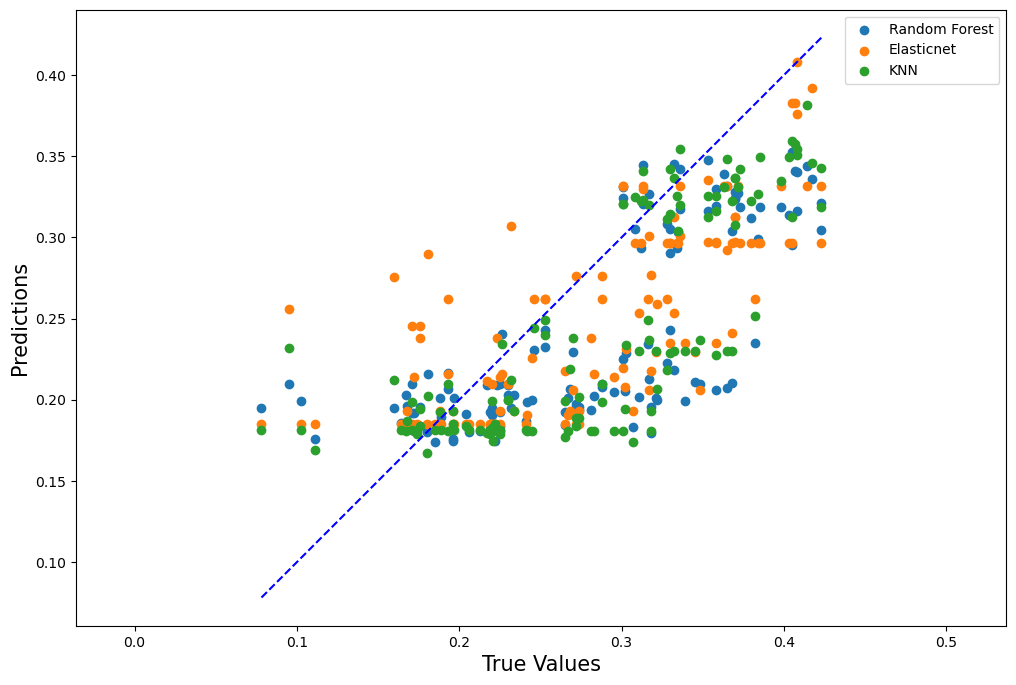

In [32]:
# Assuming you have predictions from Random Forest (y_pred_rf), XGBoost (y_pred_xgb), and LightGBM (y_pred_lgbm)
predictions = [y_pred_rf, y_pred_elasticnet, y_pred_knn]
model_names = ['Random Forest', 'Elasticnet','KNN']

# Create a scatter plot for each model's predictions
plt.figure(figsize=(12, 8))

for i, model_pred in enumerate(predictions):
    plt.scatter(y_true, model_pred, label=model_names[i])


# Calculate the axis limits to ensure the diagonal line is shown
p1 = max([max(y_true)] + [max(pred) for pred in predictions])
p2 = min([min(y_true)] + [min(pred) for pred in predictions])

# Plot the diagonal line
plt.plot([p1, p2], [p1, p2], 'b--')

# Add labels and legend
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.legend()

# Show the plot
plt.show()